# Preparación

##Imports

In [ ]:
# Imports necesarios para el notebook
from random import seed

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

# Siempre seteamos la seed de aleatoridad para que los # resultados sean reproducibles
seed(12345)
np.random.seed(12345)

sns.set_theme()

##Algoritmo

La regla Greedy elegida acá es que Sophia se quede siempre con el mas grande entre ambas opciones, mientras que Mateo "jugando" se quede siempre con la mas chica entre ambas. El concepto es que Sophia no "vea" mas adelante en turnos que el actual, es decir, solo considera las 2 opciones que tiene, siendo asi que elije siempre la mayor, porque si mirase mas adelante, no buscaria un optimo local. Al mirar de tal forma al optimo local, ella elije siempre la moneda mas grande, dando siempre la mayor sumatoria para ella. Asimismo, como buena hermana que es, elije siempre la menor moneda para Mateo, para asegurarse que siempre le quede a ella la mayor moneda para su proximo turno. Es decir, busca un "in-optimo" / suboptimo / pésimo local para Mateo.

O(n) porque se recorren todos los datos 1 vez.

O(1) cada acceso al array, append e if.

O(n) para los dos sum, O(n/2) para cada uno.

O(n) final.

In [ ]:
def turno(indicacion, arr_turnos, indice, arr_monedas, arr_datos):
    arr_turnos.append(indicacion)
    arr_monedas.append(arr_datos[indice])


# Devuelve un array segun lo pedido en Resultados_Esperados.txt
def greedy(arr_datos):
    turnos = []
    monedas_sophia = []
    monedas_mateo = []

    i_primera = 0
    i_ultima = len(arr_datos) - 1
    turno_sophia = True
    while i_primera <= i_ultima:
        if turno_sophia:
            if arr_datos[i_primera] >= arr_datos[i_ultima]:
                turno("Primera moneda para Sophia", turnos, i_primera, monedas_sophia, arr_datos)
                i_primera += 1
            else:
                turno("Última moneda para Sophia", turnos, i_ultima, monedas_sophia, arr_datos)
                i_ultima -= 1
        else:
            if arr_datos[i_primera] <= arr_datos[i_ultima]:
                turno("Primera moneda para Mateo", turnos, i_primera, monedas_mateo, arr_datos)
                i_primera += 1
            else:
                turno("Última moneda para Mateo", turnos, i_ultima, monedas_mateo, arr_datos)
                i_ultima -= 1
        turno_sophia = not turno_sophia

##util.py

En el archivo util.py se encuentra el código que mide los tiempos de ejecución de un algoritmo genérico.

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import os

# Este parámetro controla cuantas veces se ejecuta el algoritmo para cada
# tamaño. Esto es conveniente para reducir el error estadístico en la medición
# de tiempos. Al finalizar las ejecuciones, se promedian los tiempos obtenidos
RUNS_PER_SIZE = 10

# Ajustar este valor si se quiere usar más de un proceso para medir los tiempos
# de ejecución, o None para usar todos los procesadores disponibles. Si se usan
# varios procesos, tener cuidado con el uso de memoria del sistema.
MAX_WORKERS = None


def _time_run(algorithm, *args):
    start = time.time()
    algorithm(*args)
    return time.time() - start


def time_algorithm(algorithm, sizes, get_args):
    futures = {}
    total_times = {i: 0 for i in sizes}

    # Usa un ProcessPoolExecutor para ejecutar las mediciones en paralelo
    # (el ThreadPoolExecutor no sirve por el GIL de Python)
    with ProcessPoolExecutor(MAX_WORKERS) as p:
        for i in sizes:
            for _ in range(RUNS_PER_SIZE):
                futures[p.submit(_time_run, algorithm, *get_args(i))] = i

        for f in as_completed(futures):
            result = f.result()
            i = futures[f]
            total_times[i] += result

    return {s: t / RUNS_PER_SIZE for s, t in total_times.items()}

# Mediciones de tiempo


In [ ]:
def get_random_array(size: int):
    return np.random.randint(1, 1000, size)

# La variable x van a ser los valores del eje x de los gráficos en todo el notebook
# Tamaño mínimo=100, tamaño máximo=20k, cantidad de puntos=20
x = np.linspace(20, 20000, 20).astype(int)

results = time_algorithm(greedy, x, lambda s: [get_random_array(s)])

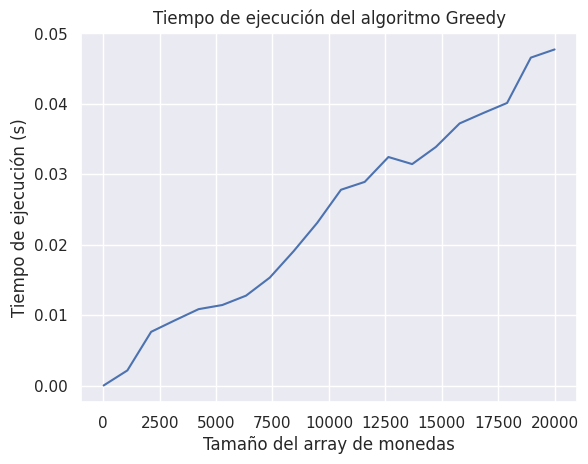

In [ ]:
ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, [results[i] for i in x], label="Medición")
ax.set_title('Tiempo de ejecución del algoritmo Greedy')
ax.set_xlabel('Tamaño del array de monedas')
ax.set_ylabel('Tiempo de ejecución (s)')
None

In [ ]:
# scipy nos pide una función que recibe primero x y luego los parámetros a ajustar:
f = lambda x, c1, c2: c1 * x * np.log(x) + c2

c, pcov = sp.optimize.curve_fit(f, x, [results[n] for n in x])

print(f"c_1 = {c[0]}, c_2 = {c[1]}")
r = np.sum((c[0] * x * np.log(x) + c[1] - [results[n] for n in x])**2)
print(f"Error cuadrático total: {r}")

c_1 = 2.3255859369337e-07, c_2 = 0.0018801958516351902
Error cuadrático total: 5.447394092493984e-05


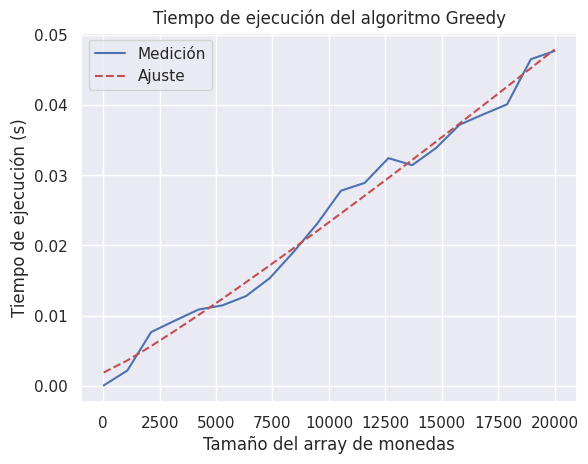

In [ ]:
ax.plot(x, [c[0] * n * np.log(n) + c[1] for n in x], 'r--', label="Ajuste")
ax.legend()
fig

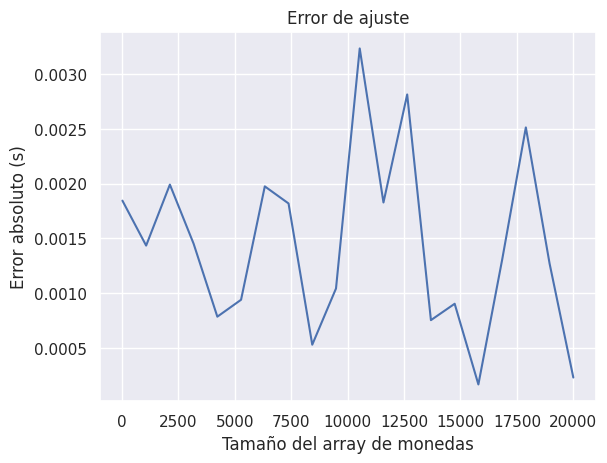

In [ ]:
ax: plt.Axes
fig, ax = plt.subplots()
errors = [np.abs(c[0] * n * np.log(n) + c[1] - results[n]) for n in x]
ax.plot(x, errors)
ax.set_title('Error de ajuste')
ax.set_xlabel('Tamaño del array de monedas')
ax.set_ylabel('Error absoluto (s)')
None